In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [2]:
# We will set the seed for reproducibility.
np.random.seed(1234)
PYTHONHASHSEED = 0

In [4]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('/content/PM_train.csv', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('/content/PM_test.csv', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [5]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [7]:
print(len(train_df))
print(len(test_df))

20631
13096


In [8]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [9]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('/content/PM_truth.csv', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [10]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


In [11]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

In [12]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [13]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

In [14]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

In [15]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


In [16]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [17]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


<Axes: >

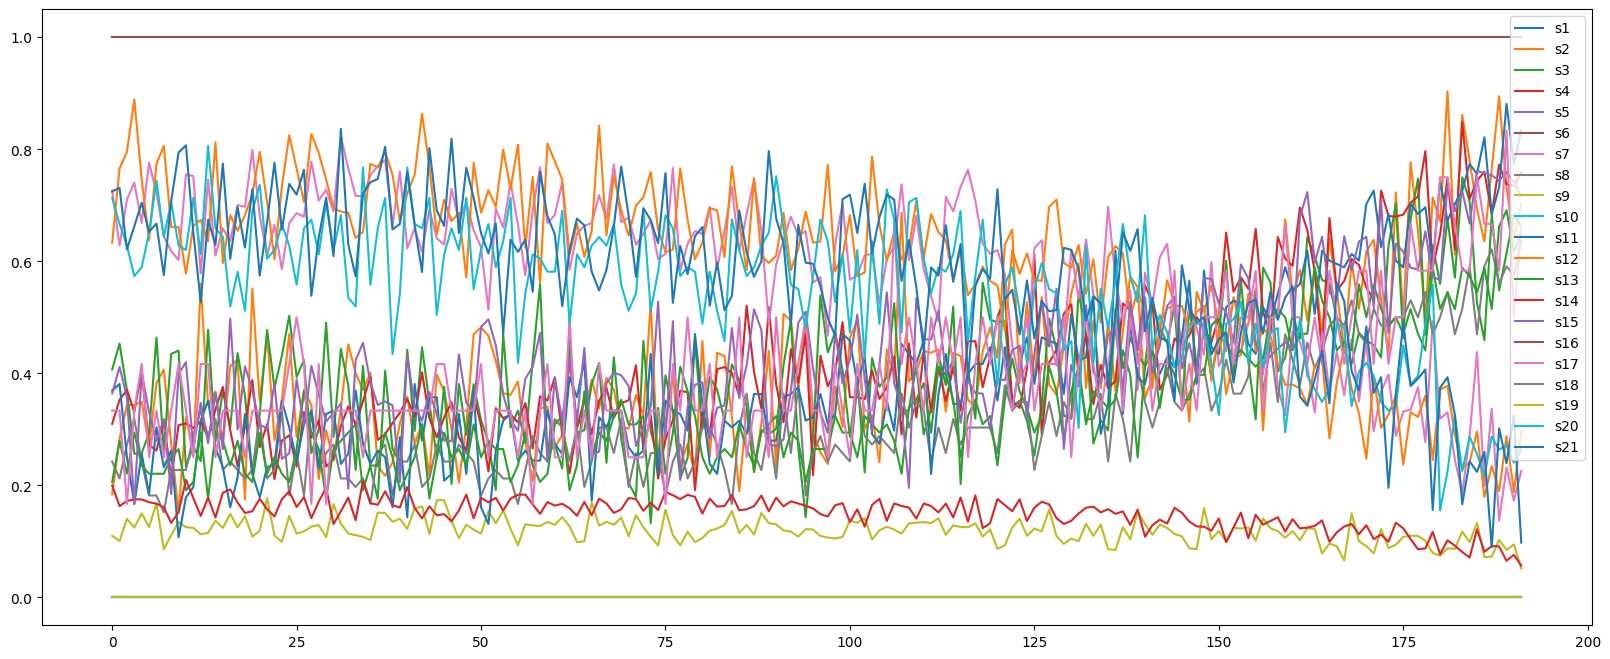

In [18]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

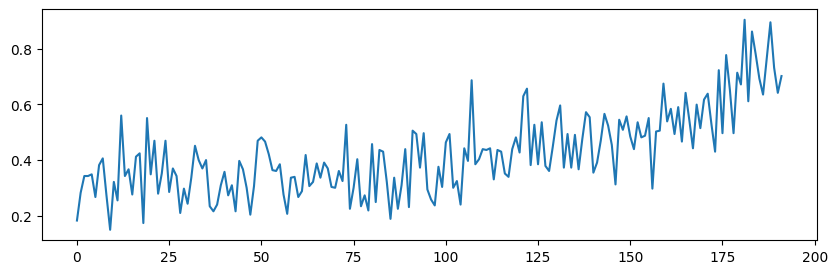

In [19]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

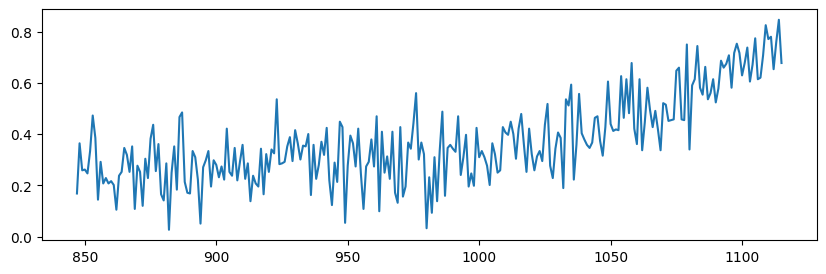

In [20]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

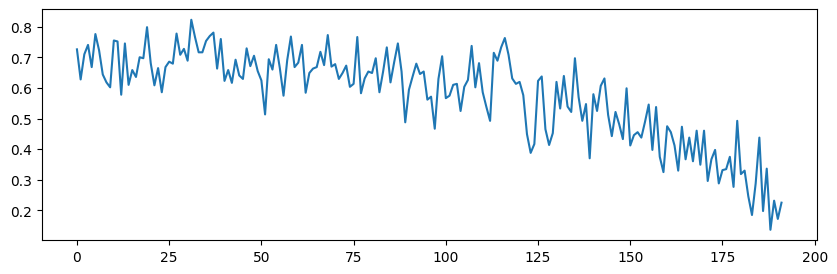

In [21]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

<Axes: >

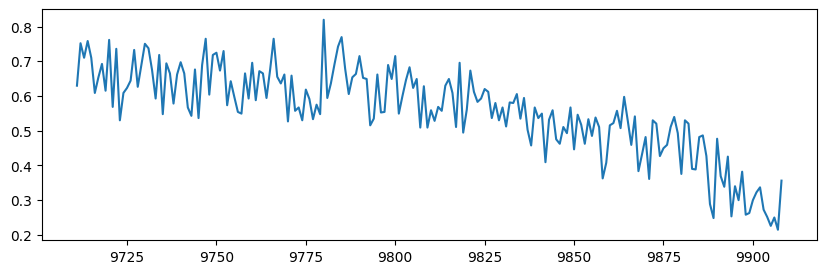

In [22]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

In [23]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [24]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [25]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

In [26]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [27]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

In [28]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()

# Add the RNN unit.
# Understand the parameters.
RNN_fwd.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=1,
         return_sequences=False))
RNN_fwd.add(Dropout(0.2))

RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = '/kaggle/working/RNN_fwd.h5'

Features dimension:  1
Output dimension:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [29]:
import time
epochs = 300
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/300
75/75 - 2s - loss: 0.6350 - accuracy: 0.7237 - val_loss: 0.6130 - val_accuracy: 0.7570 - 2s/epoch - 26ms/step
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 0s - loss: 0.6067 - accuracy: 0.7838 - val_loss: 0.5880 - val_accuracy: 0.7864 - 355ms/epoch - 5ms/step
Epoch 3/300
75/75 - 0s - loss: 0.5863 - accuracy: 0.7985 - val_loss: 0.5706 - val_accuracy: 0.7992 - 337ms/epoch - 4ms/step
Epoch 4/300
75/75 - 0s - loss: 0.5727 - accuracy: 0.8011 - val_loss: 0.5585 - val_accuracy: 0.8018 - 342ms/epoch - 5ms/step
Epoch 5/300
75/75 - 0s - loss: 0.5668 - accuracy: 0.8017 - val_loss: 0.5499 - val_accuracy: 0.8018 - 345ms/epoch - 5ms/step
Epoch 6/300
75/75 - 0s - loss: 0.5555 - accuracy: 0.8017 - val_loss: 0.5428 - val_accuracy: 0.8018 - 347ms/epoch - 5ms/step
Epoch 7/300
75/75 - 0s - loss: 0.5504 - accuracy: 0.8017 - val_loss: 0.5373 - val_accuracy: 0.8018 - 342ms/epoch - 5ms/step
Epoch 8/300
75/75 - 0s - loss: 0.5455 - accuracy: 0.8017 - val_loss: 0.5327 - val_accuracy: 0.8018 - 324ms/epoch - 4ms/step
Epoch 9/300
75/75 - 0s - loss: 0.5421 - accuracy: 0.8017 - val_loss: 0.5287 - val_accuracy: 0.8018 - 346ms/epoch - 5ms/step
Epoch 10/300
75/75 -

In [30]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

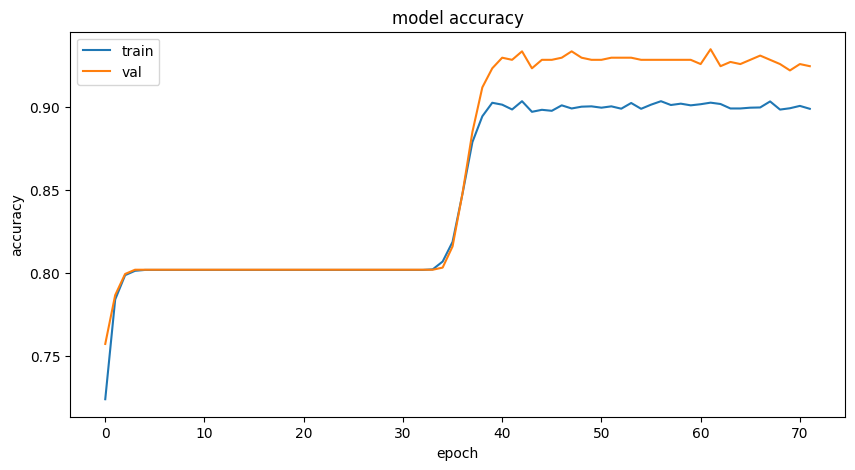

In [31]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

In [32]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

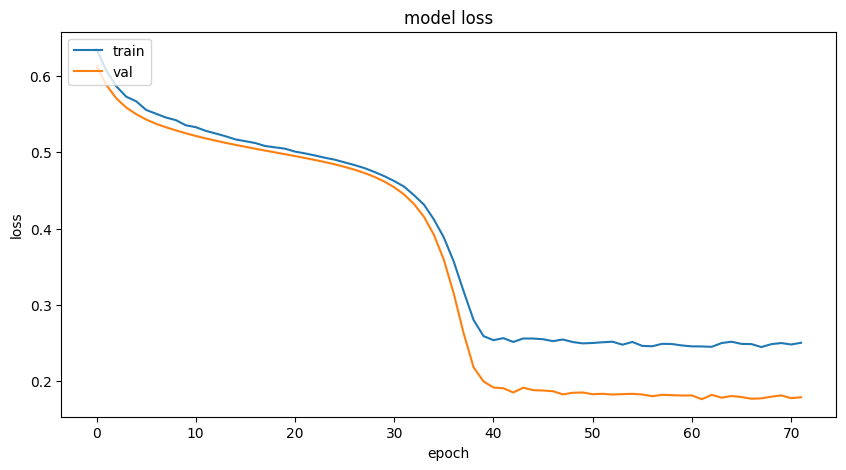

In [33]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

In [34]:
def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

313/313 [==============================] - 1s 2ms/step - loss: 0.1938 - accuracy: 0.9266
Train Accurracy: 0.9266201853752136
79/79 [==============================] - 0s 3ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12124   407]
 [  740  2360]]
Train Precision =  0.8529092880375858 
 Train Recall =  0.7612903225806451


In [35]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)

  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()

using /kaggle/working/RNN_fwd.h5
3/3 - 0s - loss: 0.2745 - accuracy: 0.9032 - 233ms/epoch - 78ms/step
Total time taken for inferencing:  0.28  secs
Test Accurracy: 0.9032257795333862
3/3 [==============================] - 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 8 17]]
Test Precision:  0.9444444444444444 
 Test Recall:  0.68 
 Test F1-score: 0.7906976744186047


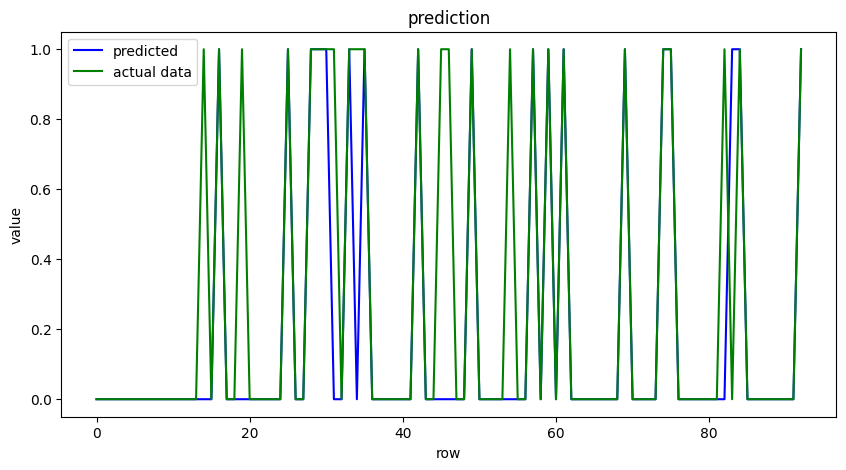

In [36]:
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

In [37]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [38]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [39]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = '/kaggle/working/RNN_fwd_2.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50, 5)             155       
                                                                 
 dropout_1 (Dropout)         (None, 50, 5)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 186 (744.00 Byte)
Trainable params: 186 (744.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

In [40]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 4s - loss: 0.7440 - accuracy: 0.5043 - val_loss: 0.6070 - val_accuracy: 0.7558 - 4s/epoch - 48ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 1s - loss: 0.5583 - accuracy: 0.7335 - val_loss: 0.4636 - val_accuracy: 0.8299 - 905ms/epoch - 12ms/step
Epoch 3/200
75/75 - 1s - loss: 0.4426 - accuracy: 0.8418 - val_loss: 0.3726 - val_accuracy: 0.8887 - 995ms/epoch - 13ms/step
Epoch 4/200
75/75 - 2s - loss: 0.3728 - accuracy: 0.8778 - val_loss: 0.3213 - val_accuracy: 0.8977 - 2s/epoch - 22ms/step
Epoch 5/200
75/75 - 2s - loss: 0.3277 - accuracy: 0.8947 - val_loss: 0.2905 - val_accuracy: 0.9066 - 2s/epoch - 20ms/step
Epoch 6/200
75/75 - 2s - loss: 0.2999 - accuracy: 0.9087 - val_loss: 0.2689 - val_accuracy: 0.9143 - 2s/epoch - 23ms/step
Epoch 7/200
75/75 - 1s - loss: 0.2747 - accuracy: 0.9153 - val_loss: 0.2388 - val_accuracy: 0.9258 - 1s/epoch - 15ms/step
Epoch 8/200
75/75 - 1s - loss: 0.2583 - accuracy: 0.9211 - val_loss: 0.2330 - val_accuracy: 0.9246 - 912ms/epoch - 12ms/step
Epoch 9/200
75/75 - 1s - loss: 0.2400 - accuracy: 0.9281 - val_loss: 0.2272 - val_accuracy: 0.9271 - 897ms/epoch - 12ms/step
Epoch 10/200
75/75 - 1s 

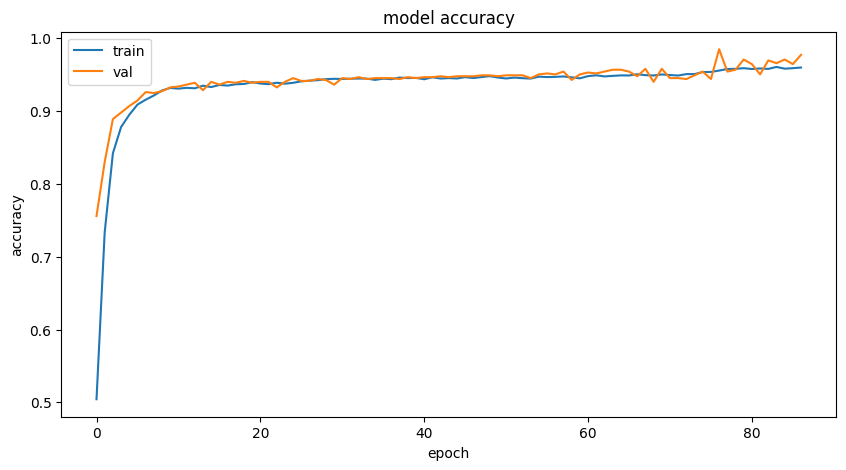

In [41]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

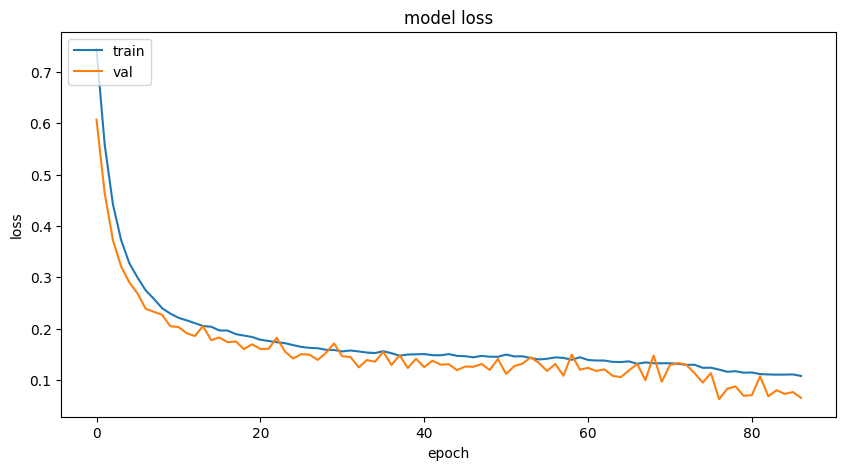

In [42]:
plot_training_curve(RNN_fwd_2_history,10,5)

In [43]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 [==============================] - 1s 3ms/step - loss: 0.0878 - accuracy: 0.9637
Train Accurracy: 0.9637259244918823
79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12197   334]
 [  233  2867]]
Train Precision =  0.8956576069978132 
 Train Recall =  0.9248387096774193


using /kaggle/working/RNN_fwd_2.h5
3/3 - 0s - loss: 0.1719 - accuracy: 0.9355 - 220ms/epoch - 73ms/step
Total time taken for inferencing:  0.26  secs
Test Accurracy: 0.9354838728904724
3/3 [==============================] - 0s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 4 21]]
Test Precision:  0.9130434782608695 
 Test Recall:  0.84 
 Test F1-score: 0.8749999999999999


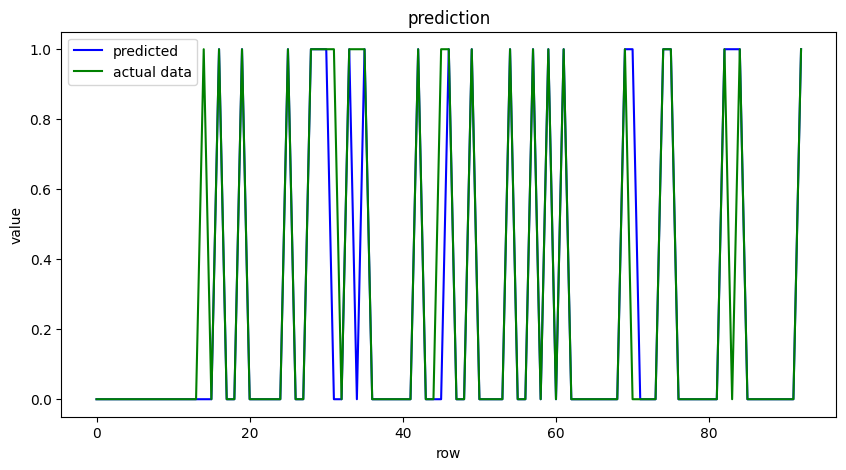

In [44]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

In [45]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()

# Understanding return_sequences and the connection across RNN layers
# Note that we have to return the sequence from the first layer so the next layer can get the sequence.

RNN_bi.add(Bidirectional( #We need to pass the RNN unit as an argument of the Bidirectional() function.
         SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=6,
         return_sequences=True)))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = '/kaggle/working/RNN_bi.h5'

Features dimension:  25
Output dimension:  1


In [46]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")



Epoch 1/200
75/75 - 4s - loss: 0.4975 - accuracy: 0.8053 - val_loss: 0.3672 - val_accuracy: 0.9041 - 4s/epoch - 57ms/step
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 - 1s - loss: 0.3376 - accuracy: 0.9121 - val_loss: 0.2967 - val_accuracy: 0.9194 - 1s/epoch - 17ms/step
Epoch 3/200
75/75 - 1s - loss: 0.2905 - accuracy: 0.9298 - val_loss: 0.2628 - val_accuracy: 0.9258 - 1s/epoch - 17ms/step
Epoch 4/200
75/75 - 1s - loss: 0.2647 - accuracy: 0.9308 - val_loss: 0.2290 - val_accuracy: 0.9412 - 1s/epoch - 17ms/step
Epoch 5/200
75/75 - 1s - loss: 0.2420 - accuracy: 0.9362 - val_loss: 0.2105 - val_accuracy: 0.9450 - 1s/epoch - 17ms/step
Epoch 6/200
75/75 - 1s - loss: 0.2266 - accuracy: 0.9364 - val_loss: 0.1933 - val_accuracy: 0.9463 - 1s/epoch - 17ms/step
Epoch 7/200
75/75 - 1s - loss: 0.2178 - accuracy: 0.9377 - val_loss: 0.1808 - val_accuracy: 0.9488 - 1s/epoch - 17ms/step
Epoch 8/200
75/75 - 1s - loss: 0.2039 - accuracy: 0.9386 - val_loss: 0.1807 - val_accuracy: 0.9488 - 1s/epoch - 17ms/step
Epoch 9/200
75/75 - 2s - loss: 0.1980 - accuracy: 0.9407 - val_loss: 0.1657 - val_accuracy: 0.9501 - 2s/epoch - 22ms/step
Epoch 10/200
75/75 - 1s - loss: 0.19

In [47]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 50, 12)            384       
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 12)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 3)                 48        
                                                                 
 dropout_4 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 436 (1.70 KB)
Trainable params: 436 (1.70 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

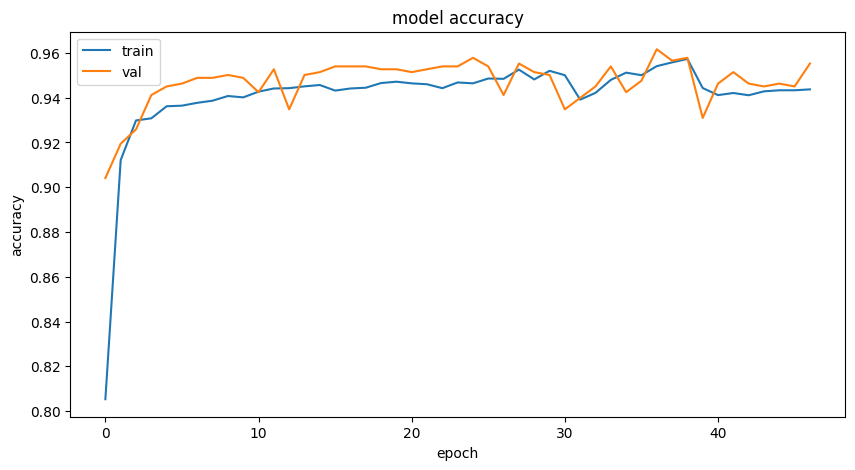

In [48]:
plot_model_accuracy(RNN_bi_history,10,5)

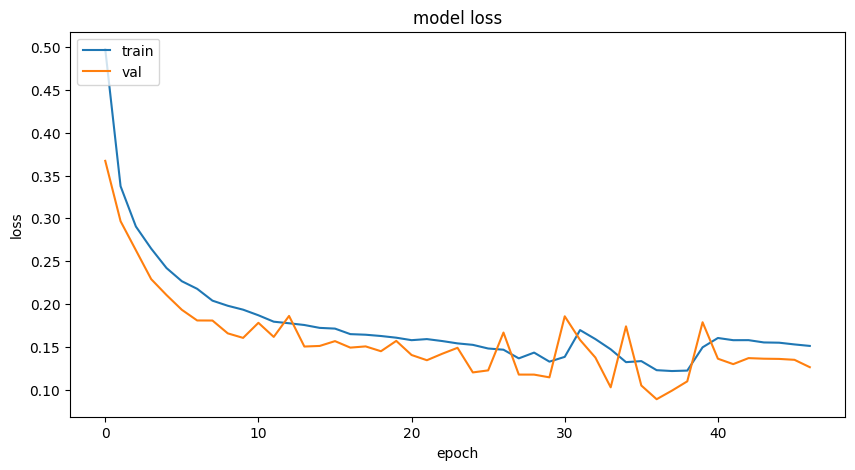

In [49]:
plot_training_curve(RNN_bi_history,10,5)

In [56]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 [==============================] - 2s 5ms/step - loss: 0.1274 - accuracy: 0.9500
Train Accurracy: 0.9499711990356445
79/79 [==============================] - 1s 7ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12199   332]
 [  450  2650]]
Train Precision =  0.8886653252850436 
 Train Recall =  0.8548387096774194


using /kaggle/working/RNN_bi.h5
3/3 - 0s - loss: 0.1197 - accuracy: 0.9355 - 347ms/epoch - 116ms/step
Total time taken for inferencing:  0.39  secs
Test Accurracy: 0.9354838728904724
3/3 [==============================] - 0s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 5 20]]
Test Precision:  0.9523809523809523 
 Test Recall:  0.8 
 Test F1-score: 0.8695652173913043


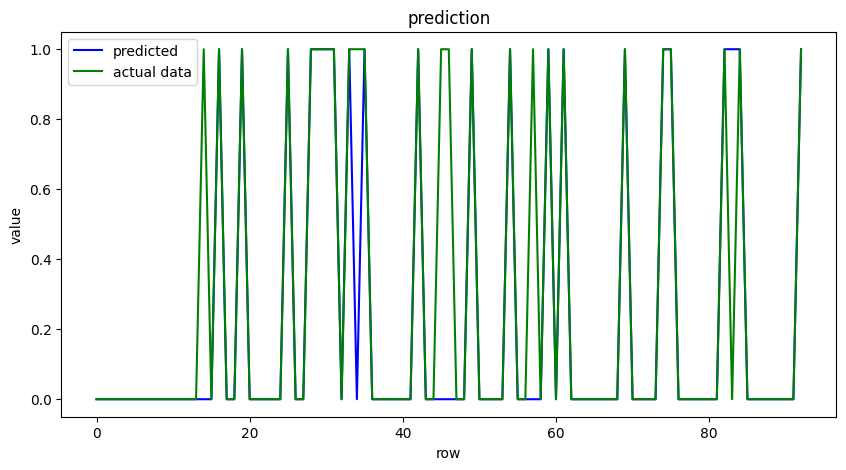

In [57]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

In [62]:
#model = (tf.keras.Sequential([
#        tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.2, input_shape=(x_train.shape[1], 1)),
#        tf.keras.layers.LSTM(50, dropout=0.2),
#        tf.keras.layers.Dense(1, activation="sigmoid"),]))

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Define path to save model
model_path = '/kaggle/working/binary_model.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout_5 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

In [65]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
history = model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 12s - loss: 0.0501 - accuracy: 0.9789 - val_loss: 0.0764 - val_accuracy: 0.9693 - 12s/epoch - 154ms/step
Epoch 2/200
75/75 - 21s - loss: 0.0436 - accuracy: 0.9814 - val_loss: 0.0463 - val_accuracy: 0.9783 - 21s/epoch - 274ms/step
Epoch 3/200
75/75 - 12s - loss: 0.0465 - accuracy: 0.9813 - val_loss: 0.0623 - val_accuracy: 0.9783 - 12s/epoch - 155ms/step
Epoch 4/200
75/75 - 11s - loss: 0.0505 - accuracy: 0.9784 - val_loss: 0.0327 - val_accuracy: 0.9834 - 11s/epoch - 143ms/step
Epoch 5/200
75/75 - 10s - loss: 0.0445 - accuracy: 0.9817 - val_loss: 0.0342 - val_accuracy: 0.9821 - 10s/epoch - 138ms/step
Epoch 6/200
75/75 - 11s - loss: 0.0481 - accuracy: 0.9793 - val_loss: 0.0392 - val_accuracy: 0.9808 - 11s/epoch - 142ms/step
Epoch 7/200
75/75 - 10s - loss: 0.0418 - accuracy: 0.9826 - val_loss: 0.0458 - val_accuracy: 0.9744 - 10s/epoch - 138ms/step
Epoch 8/200
75/75 - 10s - loss: 0.0521 - accuracy: 0.9784 - val_loss: 0.0420 - val_accuracy: 0.9795 - 10s/epoch - 135ms/step


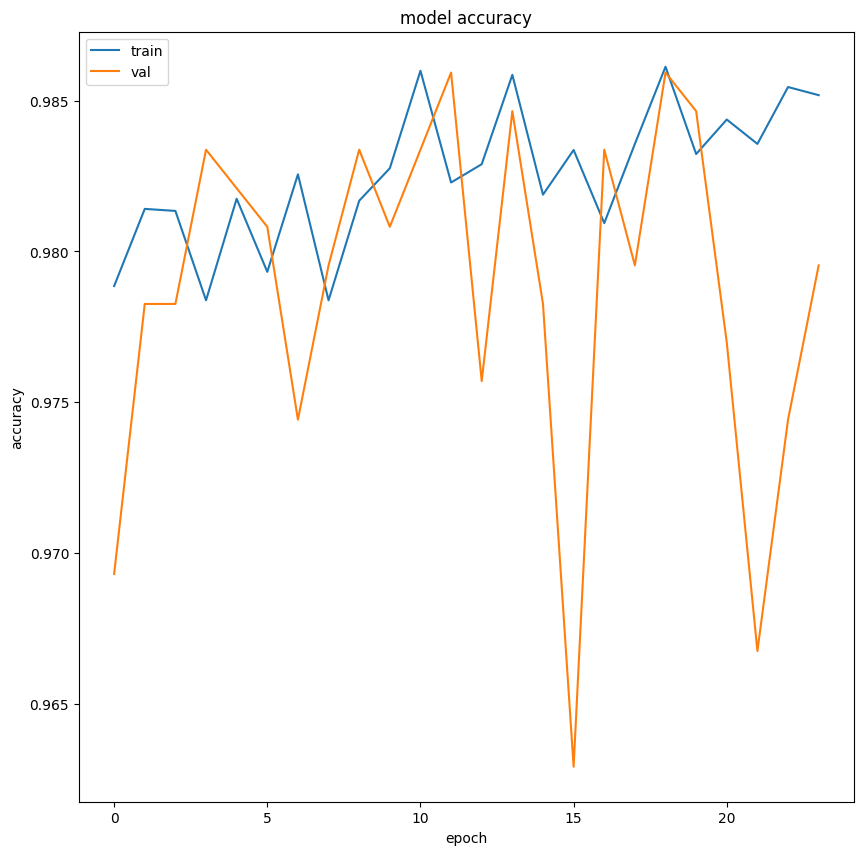

In [66]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

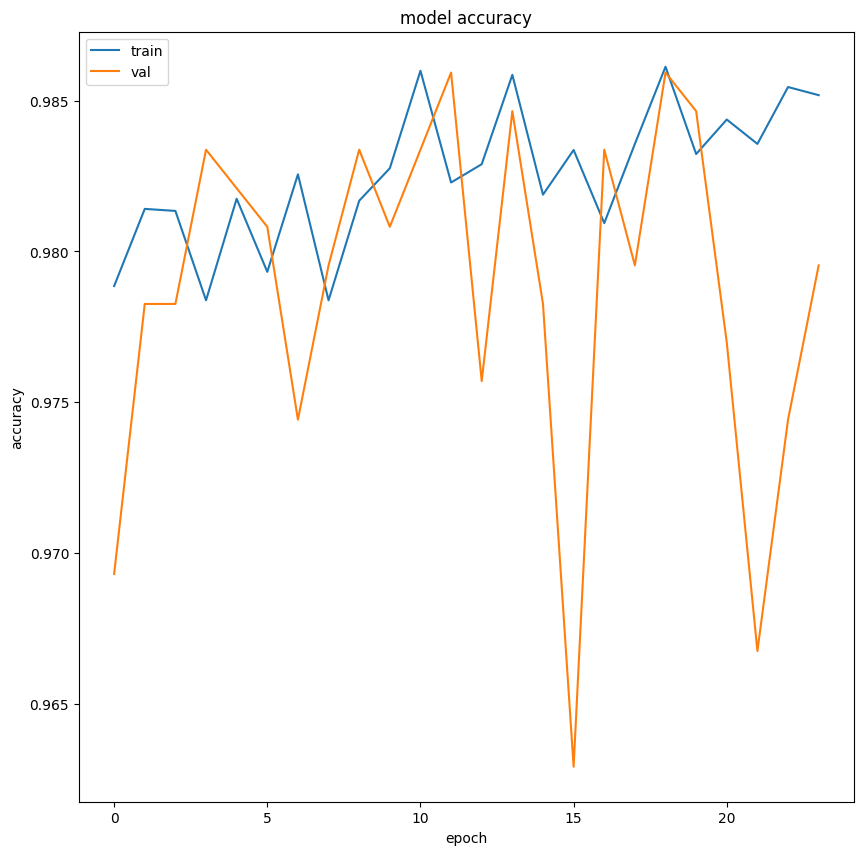

In [67]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))
# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set
test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 [==============================] - 8s 24ms/step - loss: 0.0402 - accuracy: 0.9822
Train Accurracy: 0.9822148084640503
79/79 [==============================] - 5s 57ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12279   252]
 [   26  3074]]
Train Precision =  0.9242333132892363 
 Train Recall =  0.9916129032258064


3/3 - 1s - loss: 0.0706 - accuracy: 0.9570 - 1s/epoch - 454ms/step
Total time taken for inferencing:  1.40  secs
Test Accurracy: 0.9569892287254333
3/3 [==============================] - 1s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 3 22]]
Test Precision:  0.9565217391304348 
 Test Recall:  0.88 
 Test F1-score: 0.9166666666666666


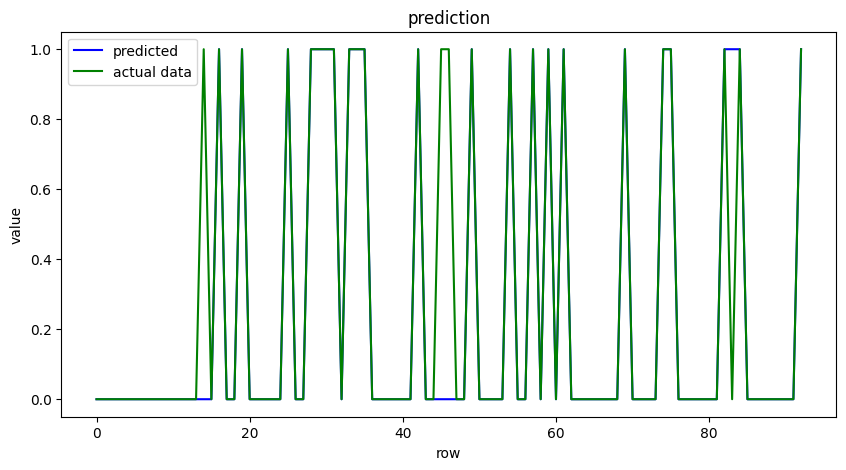

In [71]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()